### Import all packages

In [29]:
# Import packages
import os
import glob
import zipfile
import os, sys
from google.colab import drive
import torch
from PIL import Image
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch
import pickle
import cv2
import numpy as np
from torchvision.models import ResNet50_Weights
from torchvision import models
from torch.utils.data import random_split 
import copy  
from tqdm import tqdm
import datetime
import torch.nn as nn
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from torchvision import models
from itertools import chain
!pip install einops
from einops import rearrange
from torch.hub import load_state_dict_from_url

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mount Drive & Change Directory

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('drive/MyDrive/My_workspace/LEVIR_CD')

### Load in the Levir-CD using Dataloaders

In [4]:
# Define a custom sorting key to sort the Levir-CD dataset so corresponding images in each folder match
def get_numerical_value(filename):
    return int(filename.split("_")[1].split(".")[0])


# train data
images_train_A = sorted(os.listdir("train/A"), key=get_numerical_value)
images_train_B = sorted(os.listdir("train/B"), key=get_numerical_value)
images_train_mask = sorted(os.listdir("train/label"), key=get_numerical_value)


# validation data
images_valid_A = sorted(os.listdir("val/A"), key=get_numerical_value)
images_valid_B = sorted(os.listdir("val/B"), key=get_numerical_value)
images_valid_mask = sorted(os.listdir("val/label"), key=get_numerical_value)

In [5]:
# Load in the images
img1 = Image.open(os.getcwd() + '/train/A/' + images_train_A[20])
np.shape(img1) # These are the original images of resolution 1024x1024 from Levir-CD

(1024, 1024, 3)

In [6]:
# Define dataloader class to read in the images and resizes the images to 512x512

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 transform: transforms = None, path = os.getcwd(), type_data = '/train/', data_1=images_train_A, data_2=images_train_B, label=images_train_mask):

        # Get the images   
        self.old_data = path + type_data + 'A/'
        self.new_data = path + type_data +'B/'    
        self.mask_data = path + type_data + 'label/'
        self.type_data = type_data

        self.data_1 = data_1
        self.data_2 = data_2
        self.label = label

        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(512),
                transforms.CenterCrop(512),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
            ])

    def __getitem__(self, index):


        if self.type_data == '/valid/':

          pre_construction = Image.open(self.old_data + self.data_1[index])
          pre_construction = np.array(pre_construction).resize((512, 512))


          post_construction = Image.open(self.new_data + self.data_2[index])
          post_construction = np.array(post_construction).resize((512, 512))


          label = Image.open(self.mask_data + self.label[index])
          label = np.array(label).resize((512, 512))

        else:

          pre_construction = Image.open(self.old_data + self.data_1[index])
          pre_construction = np.array(pre_construction)


          post_construction = Image.open(self.new_data + self.data_2[index])
          post_construction = np.array(post_construction)


          label = Image.open(self.mask_data + self.label[index])
          label = np.array(label)


        # if image.mode != 'RGB':
        pre_construction = self.transform(pre_construction).float()
        post_construction = self.transform(post_construction).float()
        # else:
        #   image = self.transform(image)
        return pre_construction, post_construction, torch.tensor(label)

    def __len__(self):
        return len(self.data_1)

In [7]:
train_data = ImageDataset()
train_data = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)

valid_data = ImageDataset(type_data = '/val/', data_1=images_valid_A, data_2=images_valid_B, label=images_valid_mask)
valid_data = DataLoader(valid_data, batch_size=8, shuffle=False, drop_last=True)

### Load in the model and pre-trained weights of SarasNET

In [10]:
GlobalAvgPool2D = lambda: nn.AdaptiveAvgPool2d(1)

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}

class Cross_transformer_backbone(nn.Module):
    def __init__(self, in_channels = 48):
        super(Cross_transformer_backbone, self).__init__()
        
        self.to_key = nn.Linear(in_channels * 2, in_channels, bias=False)
        self.to_value = nn.Linear(in_channels * 2, in_channels, bias=False)
        self.softmax = nn.Softmax(dim=-1)

        self.gamma_cam_lay3 = nn.Parameter(torch.zeros(1))
        self.cam_layer0 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.cam_layer1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        self.cam_layer2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels*2, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, input_feature, features):
        Query_features = input_feature
        Query_features = self.cam_layer0(Query_features)       
        key_features = self.cam_layer1(features)
        value_features = self.cam_layer2(features)
        
        QK = torch.einsum("nlhd,nshd->nlsh", Query_features, key_features)
        softmax_temp = 1. / Query_features.size(3)**.5
        A = torch.softmax(softmax_temp * QK, dim=2)
        queried_values = torch.einsum("nlsh,nshd->nlhd", A, value_features).contiguous()
        message = self.mlp(torch.cat([input_feature, queried_values], dim=1))
        
        return input_feature + message

class Cross_transformer(nn.Module):
    def __init__(self, in_channels = 48):
        super(Cross_transformer, self).__init__()
        self.fa = nn.Linear(in_channels , in_channels, bias=False)
        self.fb = nn.Linear(in_channels, in_channels, bias=False)
        self.fc = nn.Linear(in_channels , in_channels, bias=False)
        self.fd = nn.Linear(in_channels, in_channels, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.to_out = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        self.gamma_cam_lay3 = nn.Parameter(torch.zeros(1))
        self.fuse = nn.Sequential(
            nn.Conv2d(in_channels * 4, in_channels, kernel_size=1, padding=0),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
    
    def attention_layer(self, q, k, v, m_batchsize, C, height, width):
        k = k.permute(0, 2, 1)
        energy = torch.bmm(q, k)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = self.softmax(energy_new)
        out = torch.bmm(attention, v)
        out = out.view(m_batchsize, C, height, width)
        
        return out
        
        
    def forward(self, input_feature, features):    
        fa = input_feature
        fb = features[0]
        fc = features[1]
        fd = features[2]
        

        m_batchsize, C, height, width = fa.size()
        fa = self.fa(fa.view(m_batchsize, C, -1).permute(0, 2, 1)).permute(0, 2, 1)
        fb = self.fb(fb.view(m_batchsize, C, -1).permute(0, 2, 1)).permute(0, 2, 1)
        fc = self.fc(fc.view(m_batchsize, C, -1).permute(0, 2, 1)).permute(0, 2, 1)
        fd = self.fd(fd.view(m_batchsize, C, -1).permute(0, 2, 1)).permute(0, 2, 1)
        
        
        qkv_1 = self.attention_layer(fa, fa, fa, m_batchsize, C, height, width)
        qkv_2 = self.attention_layer(fa, fb, fb, m_batchsize, C, height, width)  
        qkv_3 = self.attention_layer(fa, fc, fc, m_batchsize, C, height, width)
        qkv_4 = self.attention_layer(fa, fd, fd, m_batchsize, C, height, width)
        
        atten = self.fuse(torch.cat((qkv_1, qkv_2, qkv_3, qkv_4), dim = 1))
              

        out = self.gamma_cam_lay3 * atten + input_feature

        out = self.to_out(out)
        
        return out


class SceneRelation(nn.Module):
    def __init__(self,
                 in_channels,
                 channel_list,
                 out_channels,
                 scale_aware_proj=True):
        super(SceneRelation, self).__init__()
        self.scale_aware_proj = scale_aware_proj

        if scale_aware_proj:
            self.scene_encoder = nn.ModuleList(
                [nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1),
                    nn.ReLU(True),
                    nn.Conv2d(out_channels, out_channels, 1),
                ) for _ in range(len(channel_list))]
            )
        else:
            # 2mlp
            self.scene_encoder = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.ReLU(True),
                nn.Conv2d(out_channels, out_channels, 1),
            )
        self.content_encoders = nn.ModuleList()
        self.feature_reencoders = nn.ModuleList()
        for c in channel_list:
            self.content_encoders.append(
                nn.Sequential(
                    nn.Conv2d(c, out_channels, 1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(True)
                )
            )
            self.feature_reencoders.append(
                nn.Sequential(
                    nn.Conv2d(c, out_channels, 1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(True)
                )
            )

        self.normalizer = nn.Sigmoid()
        
        

    def forward(self, scene_feature, features: list):
        content_feats = [c_en(p_feat) for c_en, p_feat in zip(self.content_encoders, features)]

        scene_feats = [op(scene_feature) for op in self.scene_encoder]
        relations = [self.normalizer(sf) * cf for sf, cf in
                         zip(scene_feats, content_feats)]

        
        return relations

class PSPModule(nn.Module):
    def __init__(self, in_channels, bin_sizes=[1, 2, 4, 6]):
        super(PSPModule, self).__init__()
        out_channels = in_channels // len(bin_sizes)
        self.stages = nn.ModuleList([self._make_stages(in_channels, out_channels, b_s) 
                                                        for b_s in bin_sizes])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels+(out_channels * len(bin_sizes)), in_channels, 
                                    kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )

    def _make_stages(self, in_channels, out_channels, bin_sz):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        bn = nn.BatchNorm2d(out_channels)
        relu = nn.ReLU(inplace=True)
        return nn.Sequential(conv, bn, relu)
    
    def forward(self, features):
        h, w = features.size()[2], features.size()[3]
        pyramids = [features]

        pyramids.extend([F.interpolate(stage(features), size=(h, w), mode='bilinear', 
                                        align_corners=True) for stage in self.stages])
        output = self.bottleneck(torch.cat(pyramids, dim=1))
        return output



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out    

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, strides=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.strides = strides
        if self.strides is None:
            self.strides = [2, 2, 2, 2, 2]

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=self.strides[0], padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=self.strides[1], padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=self.strides[1], padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=self.strides[2],
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=self.strides[3],
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=self.strides[4],
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        self.channe1 = nn.Sequential(
            nn.Conv2d(256, 64, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        )            
        self.channe2 = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        ) 
        self.channe3 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        ) 
        self.channe4 = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1)
        ) 

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x) 
        x = self.bn1(x)
        x0 = self.relu(x)
        x00 = self.maxpool(x0) 
        x1 = self.layer1(x00) 
        x2 = self.layer2(x1) 
        x3 = self.layer3(x2) 
        x4 = self.layer4(x3) 
        x1 = self.channe1(x1)
        x2 = self.channe2(x2)
        x3 = self.channe3(x3)
        x4 = self.channe4(x4)
        return [x1, x2, x3, x4] 

    def forward(self, x):
        return self._forward_impl(x)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            dilation = 1
            # raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out    


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
    return model    

def resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)    

def resnet50(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

class Change_detection(nn.Module):
    # Implementing only the object path
    def __init__(self, num_classes=2, use_aux=True, fpn_out=48, freeze_bn=False, **_):
        super(Change_detection, self).__init__()

        f_channels = [64, 128, 256, 512]

        # CNN-backbone
        self.resnet = resnet50(pretrained=True, replace_stride_with_dilation=[False,True,True])       
        self.PPN = PSPModule(f_channels[-1])


        
        # Relation-aware
        self.Cross_transformer_backbone_a3 =  Cross_transformer_backbone(in_channels = f_channels[3])
        self.Cross_transformer_backbone_a2 =  Cross_transformer_backbone(in_channels = f_channels[2])
        self.Cross_transformer_backbone_a1 =  Cross_transformer_backbone(in_channels = f_channels[1])
        self.Cross_transformer_backbone_a0 =  Cross_transformer_backbone(in_channels = f_channels[0])
        self.Cross_transformer_backbone_a33 =  Cross_transformer_backbone(in_channels = f_channels[3])
        self.Cross_transformer_backbone_a22 =  Cross_transformer_backbone(in_channels = f_channels[2])
        self.Cross_transformer_backbone_a11 =  Cross_transformer_backbone(in_channels = f_channels[1])
        self.Cross_transformer_backbone_a00 =  Cross_transformer_backbone(in_channels = f_channels[0])
                
        self.Cross_transformer_backbone_b3 =  Cross_transformer_backbone(in_channels = f_channels[3])
        self.Cross_transformer_backbone_b2 =  Cross_transformer_backbone(in_channels = f_channels[2])
        self.Cross_transformer_backbone_b1 =  Cross_transformer_backbone(in_channels = f_channels[1])
        self.Cross_transformer_backbone_b0 =  Cross_transformer_backbone(in_channels = f_channels[0])
        self.Cross_transformer_backbone_b33 =  Cross_transformer_backbone(in_channels = f_channels[3])
        self.Cross_transformer_backbone_b22 =  Cross_transformer_backbone(in_channels = f_channels[2])
        self.Cross_transformer_backbone_b11 =  Cross_transformer_backbone(in_channels = f_channels[1])
        self.Cross_transformer_backbone_b00 =  Cross_transformer_backbone(in_channels = f_channels[0])


        # Scale-aware
        self.sig = nn.Sigmoid()
        self.gap = GlobalAvgPool2D()
        self.sr1 = SceneRelation(in_channels = f_channels[3], channel_list = f_channels, out_channels = f_channels[3], scale_aware_proj=True)
        self.sr2 = SceneRelation(in_channels = f_channels[2], channel_list = f_channels, out_channels = f_channels[2], scale_aware_proj=True)
        self.sr3 = SceneRelation(in_channels = f_channels[1], channel_list = f_channels, out_channels = f_channels[1], scale_aware_proj=True)
        self.sr4 = SceneRelation(in_channels = f_channels[0], channel_list =f_channels, out_channels = f_channels[0], scale_aware_proj=True)


        # Cross transformer
        self.Cross_transformer1 =  Cross_transformer(in_channels = f_channels[3])
        self.Cross_transformer2 =  Cross_transformer(in_channels = f_channels[2])
        self.Cross_transformer3 =  Cross_transformer(in_channels = f_channels[1])
        self.Cross_transformer4 =  Cross_transformer(in_channels = f_channels[0])


        # Generate change map
        self.conv_fusion = nn.Sequential(
            nn.Conv2d(960 , fpn_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(fpn_out),
            nn.ReLU(inplace=True)
        )
        
        self.output_fill = nn.Sequential(
            nn.ConvTranspose2d(fpn_out , fpn_out, kernel_size=2, stride = 2, bias=False),
            nn.BatchNorm2d(fpn_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(fpn_out, num_classes, kernel_size=3, padding=1)
        )


    def forward(self, x1, x2):
        input_size = (x1.size()[-2], x1.size()[-1])

        # CNN-backbone
        features1 = self.resnet(x1)
        features2 = self.resnet(x2)
        
        features, features11, features22= [], [],[]

        # Relation-aware
        for i in range(len(features1)):
            if i == 0:
                features11.append(self.Cross_transformer_backbone_a00(features1[i] , self.Cross_transformer_backbone_a0(features1[i], features2[i])))
                features22.append(self.Cross_transformer_backbone_b00(features2[i], self.Cross_transformer_backbone_b0(features2[i], features1[i])))
            elif i == 1:
                features11.append(self.Cross_transformer_backbone_a11(features1[i] , self.Cross_transformer_backbone_a1(features1[i], features2[i])))
                features22.append(self.Cross_transformer_backbone_b11(features2[i], self.Cross_transformer_backbone_b1(features2[i], features1[i])))
            elif i == 2:    
                features11.append(self.Cross_transformer_backbone_a22(features1[i] , self.Cross_transformer_backbone_a2(features1[i], features2[i])))
                features22.append(self.Cross_transformer_backbone_b22(features2[i], self.Cross_transformer_backbone_b2(features2[i], features1[i])))
            elif i == 3:    
                features11.append(self.Cross_transformer_backbone_a33(features1[i] , self.Cross_transformer_backbone_a3(features1[i], features2[i])))
                features22.append(self.Cross_transformer_backbone_b33(features2[i], self.Cross_transformer_backbone_b3(features2[i], features1[i])))
          
        # The distance between features from two input images.
        for i in range(len(features1)):
            features.append(abs(features11[i] - features22[i])) 
        features[-1] = self.PPN(features[-1])


        # Scale-aware and cross transformer
        H, W = features[0].size(2), features[0].size(3)
        
        c6 = self.gap(features[-1])   
        c7 = self.gap(features[-2])    
        c8 = self.gap(features[-3])    
        c9 = self.gap(features[-4])   
        
        features1, features2, features3, features4 = [], [], [], []
        features1[:] = [F.interpolate(feature, size=(64, 64), mode='nearest') for feature in features[:]]
        list_3 = self.sr1(c6, features1) 
        fe3 = self.Cross_transformer1(list_3[-1], [list_3[-2], list_3[-3], list_3[-4]]) 
        
        features2[:] = [F.interpolate(feature, size=(64, 64), mode='nearest') for feature in features[:]]
        list_2 = self.sr2(c7, features2) 
        fe2 = self.Cross_transformer2(list_2[-2], [list_2[-1], list_2[-3], list_2[-4]]) 
        
        features3[:] = [F.interpolate(feature, size=(64, 64), mode='nearest') for feature in features[:]]
        list_1 = self.sr3(c8, features3) 
        fe1 = self.Cross_transformer3(list_1[-3], [list_1[-1], list_1[-2], list_1[-4]]) 
        
        features4[:] = [F.interpolate(feature, size=(128, 128), mode='nearest') for feature in features[:]]
        list_0 = self.sr4(c9, features4) 
        fe0 = self.Cross_transformer4(list_0[-4], [list_0[-1], list_0[-2], list_0[-3]]) 

        refined_fpn_feat_list = [fe3, fe2, fe1, fe0]
    
        # Upsampling 
        refined_fpn_feat_list[0] = F.interpolate(refined_fpn_feat_list[0], scale_factor=4, mode='nearest')
        refined_fpn_feat_list[1] = F.interpolate(refined_fpn_feat_list[1], scale_factor=4, mode='nearest')
        refined_fpn_feat_list[2] = F.interpolate(refined_fpn_feat_list[2], scale_factor=4, mode='nearest')
        refined_fpn_feat_list[3] = F.interpolate(refined_fpn_feat_list[3], scale_factor=2, mode='nearest')

        # Generate change map
        x = self.conv_fusion(torch.cat((refined_fpn_feat_list), dim=1))
        x = self.output_fill(x)


        return x

In [12]:
os.getcwd()

'/content/drive/MyDrive/My_workspace/LEVIR_CD'

In [14]:
## Load in the pre-trained weights
pretrain_path = '/content/drive/MyDrive/My_workspace/LEVIR_CD/model_weight_LEVIR.pth'

device = torch.device("cuda:0")
model = Change_detection()
model = nn.DataParallel(model, device_ids = [0])
checkpoint = torch.load(pretrain_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DataParallel(
  (module): Change_detection(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNo

### Visualize results on Levir-CD dataset

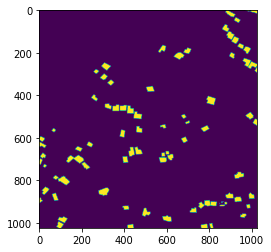

In [45]:
# Load in any image pre, post & change mask here by changing the index

img1_file = os.getcwd() + '/val/A/' + images_valid_A[13]
img2_file = os.getcwd() + '/val/B/' + images_valid_B[13]
ground_truth = os.getcwd() + '/val/label/' + images_valid_mask[13]

img1 = Image.open(img1_file)
img2 = Image.open(img2_file)
ground_truth_mask = Image.open(ground_truth)

plt.imshow(ground_truth_mask)

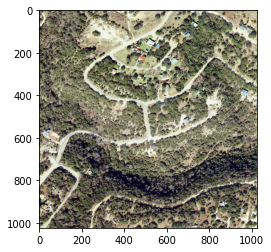

In [46]:
plt.imshow(img1)

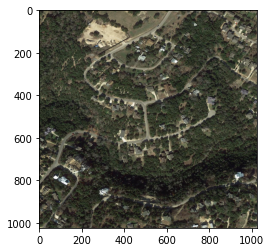

In [47]:
plt.imshow(img2)

In [56]:
# Use the pre-trained model to see what the results look like on validation data

# Function to visualize output from SarasNET on Levir-CD

def visualize_results(model, img1, img2, ground_truth_mask): # These are suppose to be in PIL image format
  patch = 256
  h1, w1 = img1.size
  gt_show = np.zeros((1024 * 2, 1024 * 2))
  show_image_0 = np.zeros((1024 * 2, 1024 * 2))
  show_image_1 = np.zeros((1024 * 2, 1024 * 2))

  for i in range(0, h1, patch):
      for j in range(0, w1, patch):
          temp_img1 = img1.crop((i, j, i+patch, j + patch )) 
          temp_img2 = img2.crop((i, j, i+patch, j + patch ))
          temp_gt   = ground_truth_mask.crop((i, j, i+patch, j + patch ))
          temp_img1 = temp_img1.resize((512,512))
          temp_img2 = temp_img2.resize((512,512))
          temp_gt   = temp_gt.resize((512,512))           
          temp_gt_acc = np.array(temp_gt,dtype= np.uint8)
          temp_gt_acc[temp_gt_acc > 0] = 1 
          height,width,_ = np.array(temp_img1,dtype= np.uint8).shape
          temp_img1 = np.array(temp_img1,dtype= np.uint8)
          temp_img2 = np.array(temp_img2,dtype= np.uint8)
          temp_gt = np.array(temp_gt,dtype= np.uint8)
          label = np.zeros((height,width,3),dtype=np.uint8)
          temp_img1 = TF.to_tensor(temp_img1)                                          
          temp_img2 = TF.to_tensor(temp_img2)                                          
          label = torch.from_numpy(label).long()                                       
          temp_img1 = TF.normalize(temp_img1, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])   
          temp_img2 = TF.normalize(temp_img2, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])   
          
           
          inputs1,inputs2, targets = temp_img1, temp_img2, label
          inputs1,inputs2,targets = inputs1.cuda(),inputs2.cuda(), targets.cuda()
          inputs1,inputs2,targets = Variable(inputs1.unsqueeze(0), volatile=True),Variable(inputs2.unsqueeze(0),volatile=True) ,Variable(targets)

          output_map = model(inputs1,inputs2)
          output_map = output_map.detach()
          
          param = 1  # This parameter is balance precision and recall to get higher F1-score
          output_map[:,1,:,:] = output_map[:,1,:,:] + param 
                      
          

          pred = output_map.argmax(dim=1, keepdim=True)
          pred = pred.cpu().detach().numpy()
          pred_acc = pred 
          pred = (pred)*255
          pred = pred.squeeze()
          gt_show[int((j//256) * 512):int((j//256) * 512)+(patch*2),int((i//256) * 512) :int((i//256) * 512) +(patch*2)] = pred
          # pred_acc = pred_acc.squeeze()

  return gt_show

<ipython-input-56-547aa0b7ee66>:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs1,inputs2,targets = Variable(inputs1.unsqueeze(0), volatile=True),Variable(inputs2.unsqueeze(0),volatile=True) ,Variable(targets)


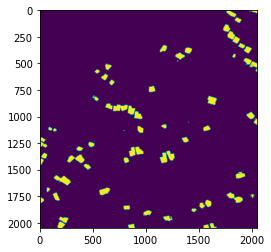

In [57]:
gt_show = visualize_results(model, img1, img2, ground_truth_mask)
plt.imshow(gt_show)

In [41]:
# Code to resize the image to 1024x1024 from 2048x2048
# ground_truth = np.array(Image.fromarray(gt_show).resize((1024,1024)))

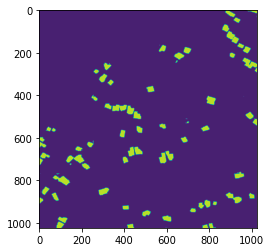

In [42]:
# plt.imshow(ground_truth)

### Load in the CDD dataset

In [65]:
# Now we load in another change detection CDD dataset 
# This dataset is mainly for changes in demographics due to seasonal variations (summer, winter etc.)
os.chdir('../CDD_dataset')

### Dataloader class for CDD data

In [80]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self,
                 transform: transforms = None, path = os.getcwd(), data_1=images_train_A, data_2=images_train_B, label=images_train_mask):

        # Get the images   
        self.data_1 = data_1
        self.data_2 = data_2
        self.label = label
        self.path = path

        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(256),
                transforms.RandomHorizontalFlip(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
            ])

    def __getitem__(self, index):


        pre_construction = Image.open(self.path + '/pre/' + self.data_1[index])
        pre_construction = np.array(pre_construction)


        post_construction = Image.open(self.path + '/post/' + self.data_2[index])
        post_construction = np.array(post_construction)


        label = Image.open(self.path + '/label/' + self.label[index])
        label = np.array(label)


        # if image.mode != 'RGB':
        pre_construction = self.transform(pre_construction).float()
        post_construction = self.transform(post_construction).float()
        # else:
        #   image = self.transform(image)
        return pre_construction, post_construction, torch.tensor(label)

    def __len__(self):
        return len(self.data_1)

In [81]:
# Load in the CDD dataset (not the full dataset!) through the dataloader class
train_data = ImageDataset()
train_data = DataLoader(train_data, batch_size=1, shuffle=True)

1.   Change SarasNET to output images of 256x256 through MaxPool2d layer

2.   Create a wraper model class that ecompasses both SarasNET & the MaxPool2d layer



In [88]:
class WrapperModel(nn.Module):
    def __init__(self, model, additional_layer):
        super(WrapperModel, self).__init__()
        self.model = model
        self.additional_layer = additional_layer

    def forward(self, x1, x2):
        x = self.model(x1, x2)
        x = self.additional_layer(x)
        # x.requires_grad = True
        return x

pretrain_path = '/content/drive/MyDrive/My_workspace/LEVIR_CD/model_weight_LEVIR.pth'

device = torch.device("cuda:0")
model = Change_detection()
model = nn.DataParallel(model, device_ids = [0])
checkpoint = torch.load(pretrain_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)
 
additional_layer = nn.MaxPool2d(kernel_size=2, stride=2)
model = WrapperModel(model, additional_layer)


model = model.to(device)

### Freeze all layers apart from the last layer 

In [83]:
# There are two ways we can do this, more advanced version is get layer names in list, freeze parameters manually, this gives more flexibility

def freeze_model_parameters(n, models):
  last_layer_names = []
  last_layer_params = []

  i = 0

  for name, param in reversed(list(models.named_parameters())):
      print(name, param.shape)
      last_layer_names.append(name)
      i += 1
      if i == n:
          break

  last_layer_params = []
  for name, param in reversed(list(models.named_parameters())):
      if name in last_layer_names:
          last_layer_params.append(param)
      if len(last_layer_params) == len(last_layer_names):
          break

  for param in models.parameters():
    param.requires_grad = False

  for param in last_layer_params:
    param.requires_grad = True

# The other way is counting the layers so when we exceed one layer, the memory requirements increase substantially for fine-tuning
# For simplicity, let us stick with this 2nd approach

  # Freeze all layers
for param in model.parameters():
    param.requires_grad = False

last_layer = list(model.children())[-1]
num_layers = len(list(model.children()))
for idx, layer in enumerate(model.children()):
    if idx >= num_layers - 1: # one layer is unfrozen
        for param in layer.parameters():
            param.requires_grad = True

### Functions for training SarasNET

In [91]:
def save_model(epoch, model, optimiser, loss, weights_path):
    """This function changes model to cpu mode, saves the model weights, epoch we reached, optimizer details,
    validation accuracy and the training loss so we can restore any model if we want to explore and compare results later on.

    Args:
        epoch (int): Number of epoch we reached at the end of training
        model (torchvision.models): Model our training function returned
        optimiser (torch.optim): Optimiser we used to train
        loss (float): Average training loss per epoch 
        weights_path (str): The path to the weights folder contained in the model evaluation directory

    """
    
    model.to('cpu')
    torch.save({
        'epoch': epoch,
        'model_state_dict': copy.deepcopy(model.state_dict()),
        'optimizer_state_dict': optimiser.state_dict(),
        'training+loss': loss}, os.path.join(weights_path, f'epoch_{epoch}_results'))

def dice_loss(predicted, target, smooth=1):
    target = target.repeat(1,2,1,1) 
    intersection = (predicted * target).sum(dim=(2, 3))
    union = predicted.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    loss = 1 - dice.mean()
    return loss

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, euclidean_distance, label):
        label = label.repeat(1,2,1,1) 
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


def iou_accuracy(pred, target, eps=1e-6):
    """
    Calculate the Intersection over Union (IoU) for the given prediction and target masks.

    Args:
        pred (torch.Tensor): Predicted mask (batch_size, 1, height, width)
        target (torch.Tensor): Ground truth mask (batch_size, 1, height, width)
        eps (float): Small value to avoid division by zero

    Returns:
        float: Mean IoU value across the batch
    """
    pred = pred > 0.5  # Apply a threshold to convert the predicted mask to binary values
    target = target > 0.5

    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    intersection = np.logical_and(pred, target).sum(axis=(1, 2, 3))
    union = np.logical_or(pred, target).sum(axis=(1, 2, 3))
    iou_scores = intersection / (union + eps)
    mean_iou = iou_scores.mean()

    return mean_iou


class ThresholdContrastiveLoss(nn.Module):
    def __init__(self, margin=1):
        super(ThresholdContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distance, target):
        """
        Args:
            output1 (torch.Tensor): Output from the first branch of the Siamese network (batch_size, 1, height, width)
            output2 (torch.Tensor): Output from the second branch of the Siamese network (batch_size, 1, height, width)
            target (torch.Tensor): Ground truth binary similarity label (batch_size,)

        Returns:
            torch.Tensor: Loss value
        """

        # Calculate the contrastive loss
        loss = (target * distance.pow(2) + (1 - target) * (self.margin - distance).clamp(min=0).pow(2)).mean()

        return loss


class ChangeDetectionLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(ChangeDetectionLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, target):
        device = logits.device
        # Convert target tensor to float dtype and move it to the same device as logits
        labels = target.squeeze(1).to(device)

        # Binary Cross-Entropy Loss
        logits = logits[:, 1, :, :].unsqueeze(1)
        
        bce_loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1))

        # Jaccard Loss
        logits = torch.sigmoid(logits)
        intersection = torch.sum(logits * labels.unsqueeze(1))
        union = torch.sum(logits) + torch.sum(labels.unsqueeze(1)) - intersection
        jaccard_loss = 1 - (intersection + self.smooth) / (union + self.smooth)

        # Combined Loss
        combined_loss = bce_loss + jaccard_loss

        return combined_loss


def train(model, device, train_loader, epochs=1):

    """This function trains the CNN model, loops through the training data for a set number of epochs, 
    calculates predictions and loss, updates gradients and model parameters, prints loss in Tensorboard, saves the model every few epochs,
    and returns the trained CNN model.

    Args:
        model (Model): CNN model 
        device (device): Whether we are working on GPU or CPU
        train_loader (DataLoader): Training data
        valid_loader (DataLoader): Validation data
        epochs (int): Number of times we loop through training data to improve our model parameters

    Returns:    
        model (Model): Trained CNN model
    """

        
     # Early stopping
    last_loss = np.inf
    running_corrects = 0
            
    optimiser = torch.optim.SGD(model.parameters(), lr=3e-5, weight_decay=3e-5)    # exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=2, gamma=0.6)
    # weight decay adds penalty to loss function, shrinks weights during backpropagation to prevent overfitting and exploding gradients
    batch_idx = 0
    total = 0 
    prev_val_acc = 0
    criterion = ThresholdContrastiveLoss().to(device)
    # criterion = torch.nn.CrossEntropyLoss().to(device)


    for epoch in range(epochs+1):
        print('\n')
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        hist_acc = [] 
        model.train()
        for _, (image1, image2, labels) in progress_bar:
            image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
            
            
            output = model(image1, image2) # the output size should be torch.Size([1, 2, 256, 256])
            # zero the parameter gradients

            optimiser.zero_grad()

            labels = labels.unsqueeze(0).resize(1, 1, 256, 256).float()
            # loss = criterion(output, labels)
            loss = criterion(output.float(), labels.float())
            # loss = contrastive_loss(output1, output2, labels, margin=1.0)
            loss.backward()

            # backward + optimize only if in training phase
            optimiser.step()

            batch_idx += 1
            acc = iou_accuracy(output, labels)
            # acc = pixel_wise_accuracy(output, labels)
            hist_acc.append(acc)
            progress_bar.set_description(f"Epoch = {epoch}/{epochs}. acc = {round(float(acc), 5)}. mean_train_acc = {round(np.mean(hist_acc), 5)}. Loss = {round(float(loss), 2)}")
            
    # torch.save(model.state_dict(), 'model_cnn')
    torch.save(model, 'SM_Fine_tuned_LEVIR_model.pth') # save the final model as well for comparison 
    print('End of epochs reached with best model saved in final_models')
    return model

### Fine-tune the model on CDD dataset images

In [92]:
model_cnn = train(model, device, train_data, epochs=10)

Epoch = 0/10. acc = 0.0285. mean_train_acc = 0.10404. Loss = -37.51: 100%|██████████| 34/34 [00:48<00:00,  1.43s/it]


Epoch = 1/10. acc = 0.0. mean_train_acc = 0.0688. Loss = -61.93: 100%|██████████| 34/34 [00:16<00:00,  2.09it/s]


Epoch = 2/10. acc = 0.0. mean_train_acc = 0.00899. Loss = -86.27: 100%|██████████| 34/34 [00:16<00:00,  2.05it/s]


Epoch = 3/10. acc = 0.09749. mean_train_acc = 0.01023. Loss = 59.75: 100%|██████████| 34/34 [00:16<00:00,  2.02it/s]


Epoch = 4/10. acc = 0.0. mean_train_acc = 0.00684. Loss = -1519.87: 100%|██████████| 34/34 [00:16<00:00,  2.07it/s]


Epoch = 5/10. acc = 0.0. mean_train_acc = 0.00388. Loss = 202.96: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]


Epoch = 6/10. acc = 0.04289. mean_train_acc = 0.0075. Loss = 498.08: 100%|██████████| 34/34 [00:16<00:00,  2.09it/s]


Epoch = 7/10. acc = 0.00134. mean_train_acc = 0.00576. Loss = -6391.22: 100%|██████████| 34/34 [00:16<00:00,  2.07it/s]


Epoch = 8/10. acc = 0.03423. mean_train_acc = 0.00784. Loss = 601.21: 100%|██████████| 34/34 [00:16<00:00,  2.06it/s]


Epoch = 9/10. acc = 0.0. mean_train_acc = 0.00367. Loss = -3208.83: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]


Epoch = 10/10. acc = 0.0. mean_train_acc = 0.00344. Loss = -267.61: 100%|██████████| 34/34 [00:16<00:00,  2.06it/s]


End of epochs reached with best model saved in final_models


### Visualize the results 

In [93]:
images_train_A = sorted(os.listdir("pre/"))
images_train_B = sorted(os.listdir("post/"))
images_train_mask = sorted(os.listdir("label/"))

path = os.getcwd()
img1 = Image.open(path + '/pre/' + images_train_A[20])
img2 = Image.open(path + '/post/' + images_train_B[20])
gt =   Image.open(path + '/label/' + images_train_mask[20])

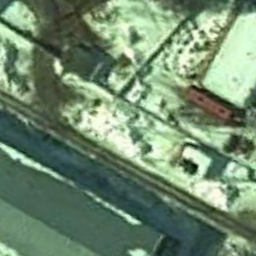

In [94]:
img1

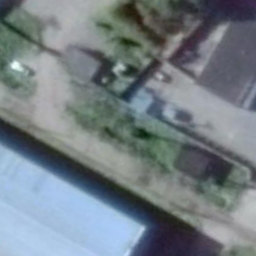

In [95]:
img2

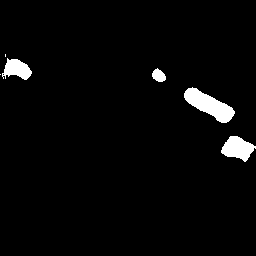

In [96]:
gt

In [97]:
np.shape(gt)

(256, 256)

(256, 256, 3)
(256, 256, 3)
torch.Size([3, 256, 256])


<ipython-input-98-bfc7eadc7c32>:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs1,inputs2 = Variable(inputs1.unsqueeze(0), volatile=True),Variable(input2.unsqueeze(0),volatile=True)


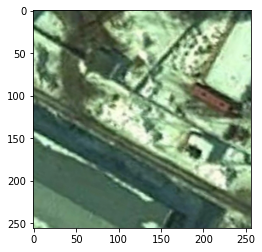

In [98]:
# model
temp_img1 = img1.convert('RGB')
print(np.shape(temp_img1))
plt.imshow(temp_img1)
temp_img2 = img2.convert('RGB')
gt_show   = gt.convert('RGB')


temp_gt_acc = np.array(gt_show,dtype= np.uint8)
temp_gt_acc[temp_gt_acc > 0] = 1
height,width,_ = np.array(temp_img1,dtype= np.uint8).shape
temp_img1 = np.array(temp_img1,dtype= np.uint8)
print(np.shape(temp_img1))
temp_img2 = np.array(temp_img2,dtype= np.uint8)
temp_gt = np.array(np.array(gt_show),dtype= np.uint8)

temp_img1 = TF.to_tensor(temp_img1)                                          
temp_img2 = TF.to_tensor(temp_img2)                                          
print(temp_img1.size())

temp_img1 = TF.normalize(temp_img1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   
temp_img2 = TF.normalize(temp_img2, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  

inputs1,input2 = temp_img1, temp_img2
inputs1,input2 = inputs1.to(device),input2.to(device)

inputs1,inputs2 = Variable(inputs1.unsqueeze(0), volatile=True),Variable(input2.unsqueeze(0),volatile=True) 

output_map = model(inputs1,inputs2)
patch = 256
h1, w1 = img2.size
gt_show = np.zeros((256, 256))

for i in range(0, h1, patch):
    for j in range(0, w1, patch):
        output_map = output_map.detach()

        param = 1  # This parameter is balance precision and recall to get higher F1-score
        output_map[:,1,:,:] = output_map[:,1,:,:] + param 
                    


        pred = output_map.argmax(dim=1, keepdim=True)
        pred = pred.cpu().detach().numpy()
        pred_acc = pred 
        pred = (pred)*255
        pred = pred.squeeze()
        gt_show[int((j//256) * 512):int((j//256) * 512)+(patch*2),int((i//256) * 512) :int((i//256) * 512) +(patch*2)] = pred

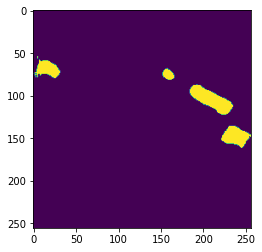

In [100]:
plt.imshow(gt)

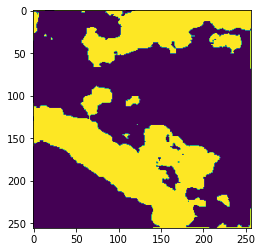

In [99]:
plt.imshow(gt_show)